# Simulating Circuits with the Restless Simulator

The restless simulator can be used to simulate restless circuit execution of single-qubit/qutrit
circuits, where qubit/qutrit reset is skipped. This means that the input-state of a circuit may not
be the ground state $\ket{0}$. In this notebook you will learn how to create a restless simulator
instance, how to post-process the restless data to recover the standard circuit-execution
measurements, what options are available to modify the simulation, and how to execute qutrit
circuits **with** qubit/qutrit reset.


## Running qubit circuits with restless


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit

from restless_simulator.simulator import QutritRestlessSimulator

You can construct a restless simulator from the `QutritRestlessSimulator` class. To demonstrate how
the simulator works, we will create a series of single-qubit circuits with an initial $RX(\pi/2)$
gate and an increasing number of identical $RX(\pi/3)$ gates. We do not need to add measurements as
these are implicitly applied by the simulator. We will start with qubit gates. The simulator treats
all qubits as qutrits, and will automatically embed qubit-gates in SU(3) such that the $|2\rangle$
population never changes.


In [2]:
simulator = QutritRestlessSimulator()

Here we create 10 circuits with increasing number of $RX(\pi/3)$ gates. Note that we do not add
measurements or classical registers, these are included implicitly by the simulator.


In [3]:
circuits = []
N_CIRCUITS = 10
for n in range(N_CIRCUITS):
    nth_circ = QuantumCircuit(1)
    # Each circuit starts with an RX(pi/2) gate
    nth_circ.rx(np.pi / 2, 0)
    for _ in range(n):
        nth_circ.rx(np.pi / 3, 0)
    circuits.append(nth_circ)

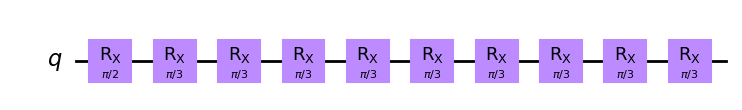

In [4]:
circuits[-1].draw("mpl")

We execute our circuits with the simulator by calling `run()`. The default configuration of the
simulator will execute circuits with restless and without post-measurement error. This means that
the post-measurement state is the collapsed measurement state. The simulator defaults to qubit
discrimination, which labels the $|1\rangle$ and $|2\rangle$ states as the state-label "1". The
returned `job` object contains all results for our circuit execution, but the measurement outcomes
need to be post-processed to reconstruct the standard measurements (i.e., as if we had not used
restless circuit execution).


In [5]:
job = simulator.run(circuits)

## Restless post-processing

The following cells contain functions to run restless post-processing. They do the following:

1.  `extract_memory`: Extracts a 2D array of single-shot measurement outcomes (i.e., memory) from a
    job instance. If we used restless circuit execution, these outcomes would be the restless memory
    outcomes. Later on we will see how to emulate standard circuit execution with the simulator.
2.  `restless_memory_to_memory`: Converts restless memory outcomes to standard memory outcomes by
    1.  reshaping the memory array into a time-ordered sequence of outcomes,
    2.  taking the exclusive OR between successive measurement outcomes (as required by restless
        circuit execution),
    3.  and then reshaping the results to match the expected shape of a memory array (i.e., circuits
        x shots).
3.  `memory_to_probabilities`: Reconstructs the probability to measure an outcome based on the
    number of occurrences of said outcome in a memory array.

These three functions can be used in sequence to obtain the probability to measure $|0\rangle$ for
each circuit, even if restless circuit execution was used.


In [6]:
from restless_simulator.simulator import RestlessJob


def extract_memory(in_job: RestlessJob) -> np.ndarray:
    """Extract memory from ``in_job``, returned as a 2D NumPy array of single-shot outcome
    labels.

    Args:
        in_job: A :class:`RestlessJob` instance.

    Returns:
        A 2D NumPy array of shape ``(N_CIRCUITS, n_shots)`` containing the results of the job.
    """
    results = in_job.result().results
    # Convert single-shot results from hexadecimal strings to integers. Expected values are 0, 1,
    # and 2.
    memory = np.array(
        [list(map(lambda x: str(int(x, 16)), res.data.memory)) for res in results]
    )

    return memory

In [7]:
def restless_memory_to_memory(memory: np.ndarray) -> np.ndarray:
    """Convert restless memory measurements into standard measurements.

    This function applies restless post-processing to memory outcomes. It assumes that ``memory`` is
    a 2D array of shape ``(N_CIRCUITS, n_shots)`` where the circuits and shots are time-ordered. It
    also assumes that the entries are either of the strings ``"0"`` and ``"1"``.

    Args:
        memory: A 2D NumPy array of restless single-shot measurements.

    Returns:
       A 2D array of the same shape as ``memory``, but with the post-processed standard measurement
       outcomes based on restless circuit execution.
    """
    initial_shape = memory.shape
    ## Reshape memory into time-ordered shots, i.e.,
    # shots[0] -> circuit 0 shot 0
    # shots[1] -> circuit 1 shot 0
    # ...
    # shots[N_CIRCUITS] -> circuit 0 shot 1
    # ...
    memory = memory.reshape((-1), order="F").astype(int)

    ## Add input ground-state and compute XOR difference to reconstruct standard measurement
    ## outcomes.

    # input states, assuming initial ground-state
    input_memory = np.roll(memory, 1)
    input_memory[0] = 0

    # Return XOR between measurements and input states.
    processed_memory = np.logical_xor(memory, input_memory).astype(int).astype(str)

    # Return processed memory as original shape
    return np.reshape(processed_memory, initial_shape, order="F")

In [8]:
def memory_to_probabilities(memory: np.ndarray, outcome="0") -> np.ndarray:
    """Converts a memory array into a list of reconstructed probabilities to measure ``outcome``.

    This is done by dividing the number of occurrences $N_i$ of the outcome ``"i"`` in the memory
    array by the number of shots (i.e., ``memory.shape[1]``). This process is done along the second
    axis of ``memory`` so that there are individual probabilities per circuit.

    Args:
        memory: A 2D array of measurement outcomes ``"0"`` and ``"1"``, with shape ``(N_CIRCUITS,
            n_shots)``.
        outcome: The outcome label for the probabilities, either ``"0"`` or ``"1"``. Defaults to
            "0".

    Returns:
        A 1D array of reconstructed probabilities to measure ``outcome`` for each circuit.
    """
    return np.sum(memory == outcome, axis=1) / memory.shape[1]

Here we reconstruct the standard measurement outcomes from the restless measurement outcomes using
the above functions.


In [9]:
restless_outcomes = extract_memory(job)
reconstructed_outcomes = restless_memory_to_memory(restless_outcomes)
reconstructed_probs = memory_to_probabilities(reconstructed_outcomes)

As a comparison, we also compute the outcome probabilities without restless post-processing step,
i.e., `restless_memory_to_memory`. These probabilities should give us very little insight into the
behaviour of the circuits as we have not corrected for the lack of qubit/qutrit reset.


In [10]:
naive_probs = memory_to_probabilities(restless_outcomes)

As our circuits contain repeated applications of the $RX(\pi/3)$ gate, we know how to compute the
ideal probabilities analytically. If we represent the probability to measure `"0"` $P_0[n]$ as a
function of the number of $RX(\pi/3)$ gates $n$, we get the following cosine.

$$
P_0[n] = \frac{1}{2}\cos{\left(\frac{\pi}{3}n + \frac{\pi}{2}\right)} + \frac{1}{2}
$$

The additional phase in the cosine accounts for the initial $RX(\pi/2)$ gate in the circuits.


In [11]:
expected_probs = (
    0.5 * np.cos(np.pi / 3 * np.arange(N_CIRCUITS, step=0.1) + np.pi / 2) + 0.5
)

Now we plot the
1. reconstructed probabilities,
2. naive probabilities (i.e., without restless post-processing),
3. and the cosine function of the ideal probabilities, interpolated to real $n$ values.


Text(0, 0.5, 'Probability to Measure $|0\\rangle$')

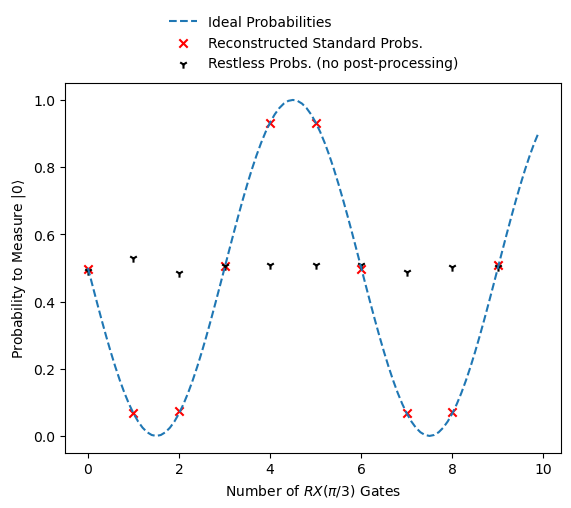

In [12]:
plt.plot(
    np.arange(N_CIRCUITS, step=0.1),
    expected_probs,
    label="Ideal Probabilities",
    linestyle="--",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(restless_memory_to_memory(extract_memory(job))),
    label="Reconstructed Standard Probs.",
    marker="x",
    color="r",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(extract_memory(job)),
    label="Restless Probs. (no post-processing)",
    marker="1",
    color="k",
)

plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), frameon=False)
plt.xlabel("Number of $RX(\\pi/3)$ Gates")
plt.ylabel("Probability to Measure $|0\\rangle$")

As you can see, the expected probabilities are accurately recovered by applying restless
post-processing on the restless measurements. Without this post-processing step, the measurement
outcomes are all at roughly $0.5$, which gives us very little insight into the circuits' behaviour.


## Circuits with Qutrit Gates


Creating circuits with qutrit gates is easy, as the `restless_simulator` library provides special gates
to include SU(3) unitaries and qutrit CPTP maps as circuit instructions: i.e., using classes
`QutritUnitaryGate` and `QutritQuantumChannelOperation`.


In [13]:
from restless_simulator.circuit import QutritUnitaryGate

In this section we will look at replacing the initial $RX(\pi/2)$ gate with a leaky variant. This
leaky gate will reduce the contrast of our measurements as the $|2\rangle$ population will now be
non-zero. All $RX(\pi/3)$ gates remain "ideal" in that they do not interact with the
$|2\rangle$-state population. The default measurement assignment for the simulator assigns the `"1"`
label to the `|2\rangle` state, which means that by default it cannot distinguish between
$|1\rangle$ and $|2\rangle$. This can be changed by setting the `meas_assignment_mat` option of the
simulator.

First we create a NumPy array of our leaky unitary gate as an ideal $RX(\pi/2)$ rotation between
$|0\rangle$ and $|1\rangle$ and a small rotation from $|1\rangle$ into the $|2\rangle$ state. This
final rotation is controlled by the $\gamma$ parameter.


In [14]:
# Variable to control leakage
gamma = np.pi / 16
# Construct leaky gate as two rotations.
leaky_unitary = (
    # very small rotation from |1> to |2>
    np.array(
        [
            [1, 0, 0],
            [0, np.cos(gamma / 2), -1j * np.sin(gamma / 2)],
            [0, -1j * np.sin(gamma / 2), np.cos(gamma / 2)],
        ],
    )
    # X-pi/2 rotation between |0> and |1>
    @ np.array(
        [
            [np.cos(np.pi / 4), -1j * np.sin(np.pi / 4), 0],
            [-1j * np.sin(np.pi / 4), np.cos(np.pi / 4), 0],
            [0, 0, 1],
        ]
    )
)

Now that we have our leaky unitary, we create an instance of `QutritUnitaryGate` with our unitary
matrix. We then construct new leaky circuits and append our leaky gate as the first gate. The
execution of our circuits is exactly the same.


In [15]:
leaky_gate = QutritUnitaryGate(leaky_unitary, label="U")

In [16]:
leaky_circuits = []
for n in range(N_CIRCUITS):
    nth_circ = QuantumCircuit(1)
    # Add leaky gate to qubit/qutrit 0.
    nth_circ.append(
        leaky_gate,
        [0],
    )
    # Add ideal qubit RX(pi/3) gates.
    for _ in range(n):
        nth_circ.rx(np.pi / 3, 0)
    leaky_circuits.append(nth_circ)

In [17]:
leaky_job = simulator.run(leaky_circuits)

If we plot the reconstructed probabilities for the leaky and non-leaky gates, we can see that the
contrast of the leaky measurements (green circles) is less than the non-leaky gates (red Xs).


Text(0, 0.5, 'Probability to Measure $|0\\rangle$')

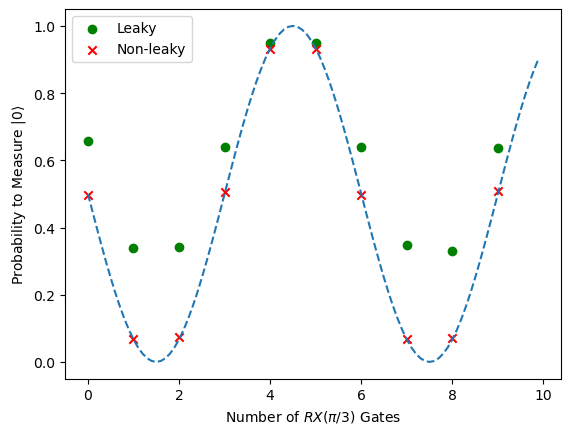

In [18]:
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(restless_memory_to_memory(extract_memory(leaky_job))),
    label="Leaky",
    marker="o",
    color="g",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(restless_memory_to_memory(extract_memory(job))),
    label="Non-leaky",
    marker="x",
    color="r",
)
plt.plot(np.arange(N_CIRCUITS, step=0.1), expected_probs, linestyle="--")
plt.legend()
plt.xlabel("Number of $RX(\\pi/3)$ Gates")
plt.ylabel("Probability to Measure $|0\\rangle$")

## Standard Circuit Execution

If we want, we can emulate qubit/qutrit reset with the `RestlessSimulator` by setting the
post-measurement transition matrix to implement reset. This allows us to execute qutrit circuits
with standard circuit execution.

`RestlessSimulator` simulates circuits using transition matrices, which capture measurement
probabilities as a Markov Chain. It also simulates post-measurement error as a transition matrix.
This matrix, for a single qutrit, contains the probability $p_{ij}$ to have state $|i\rangle$ as the
output given state $|j\rangle$ as the input. The post-measurement transition matrix is given by

$$
P_k = \begin{pmatrix}
p_{00}  &   p_{01}  &   p_{02}  \\
p_{10}  &   p_{11}  &   p_{12}  \\
p_{20}  &   p_{21}  &   p_{22}  \\
\end{pmatrix}.
$$

To implement reset, we set the post-measurement transition matrix such that the probability to have
the ground-state as the output $P_{0j}$ is always equal to one, i.e.,

$$ P_{reset}=\begin{pmatrix}
1&1&1\\
0&0&0\\
0&0&0\\
\end{pmatrix}.
$$

We pass this post-measurement transition matrix to the simulator in `run()` as the
`meas_transition_mats` parameter. Passing a single 3x3 NumPy array will use the same transition
matrix for each cicuit. We can also pass a list of 10 3x3 matrices, which tells the simulator to
match each circuit with a corresponding array in said list.


In [19]:
# Create qutrit-reset transition matrix.
P_reset = np.array([[1, 1, 1], [0, 0, 0], [0, 0, 0]])

In [20]:
# Execute leaky circuits with standard circuit execution.
standard_job = simulator.run(leaky_circuits, meas_transition_mats=P_reset)

If we plot the reconstructed probabilities with restless and standard circuit execution, we see that
standard circuit execution results in probabilities that are close to the expected ideal (i.e., the
cosine plot). This shows us that restless circuit execution is sensitive to leakage and that qutrit
reset mitigates the impact of leakage on measurement outcomes.


Text(0, 0.5, 'Probability to Measure $|0\\rangle$')

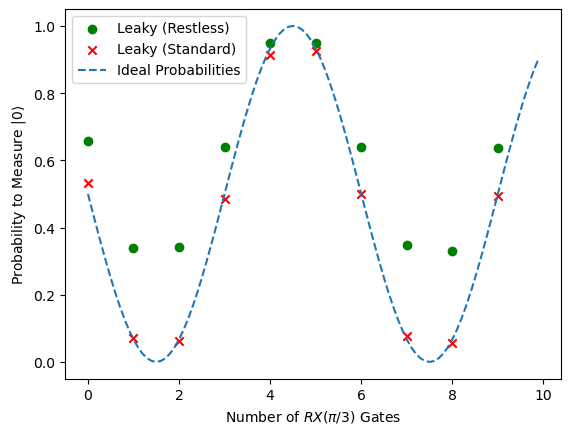

In [21]:
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(restless_memory_to_memory(extract_memory(leaky_job))),
    label="Leaky (Restless)",
    marker="o",
    color="g",
)
plt.scatter(
    range(N_CIRCUITS),
    memory_to_probabilities(extract_memory(standard_job)),
    label="Leaky (Standard)",
    marker="x",
    color="r",
)
plt.plot(
    np.arange(N_CIRCUITS, step=0.1),
    expected_probs,
    linestyle="--",
    label="Ideal Probabilities",
)
plt.legend()
plt.xlabel("Number of $RX(\\pi/3)$ Gates")
plt.ylabel("Probability to Measure $|0\\rangle$")

## Leakage Rate in Measurements


If we want to investigate the measurement states prior to measurement assignment, we can pass
`return_meas_state=True` to the simulator's `run()` method. The returned job object will then
contain lists of measurement labels which indicate the collapsed state prior to measurement
assignment error. These are the qutrit state labels '0', '1', and '2'. We can access these by
calling `meas_state` on a result instance, retrieved from `job.results()`. As we execute 10
circuits, there are 10 result instances; each with a `meas_state` list.

Below we 1. execute circuits with and without qutrit reset and with `return_meas_state=True`, 2.
collect the collapsed measurement state labels into a single array, 3. and compute the leakage rate
for the measurement outcomes.

This allows us to compare the frequency of the $|2\rangle$ state in our measurements with standard
and
restless circuit execution.


In [22]:
# Execute with qutrit reset
standard_job_meas_state = simulator.run(
    leaky_circuits, meas_transition_mats=P_reset, return_meas_state=True
)

# Execute with restless and without qutrit reset
restless_job_meas_state = simulator.run(leaky_circuits, return_meas_state=True)

In [23]:
# Collect collapsed measurement state labels
standard_measurement_states = np.array(
    [result.meas_state for result in standard_job_meas_state.result().results]
).astype(str)
restless_measurement_states = np.array(
    [result.meas_state for result in restless_job_meas_state.result().results]
).astype(str)

# Compute rate at which we measured the |2> state
standard_leakage_rate = (
    np.sum(standard_measurement_states == "2") / standard_measurement_states.size
)
restless_leakage_rate = (
    np.sum(restless_measurement_states == "2") / restless_measurement_states.size
)
print(
    f"Leakage rates were {standard_leakage_rate:0.4g} for standard execution and "
    f"{restless_leakage_rate:0.4g} for restless."
)

Leakage rates were 0.005469 for standard execution and 0.3551 for restless.


As we see in the above leakage rates, standard circuit execution suppresses the rate at which we
would measure the $|2\rangle$ state. If our circuits were less leaky, these rates would be lower.
Though leakage impacts restless circuit execution, we do get a large increase in circuit execution
speed. Before running a leaky or leakage-sensitive experiment with restless circuit execution, you
should make sure to analyse the trade-off between the speed gain and the negative impact of leakage
on the measurement outcomes.
